In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
# Loading the dataset
exchange_rates = pd.read_csv("D:/Exchange_Rates.csv", encoding='latin1')
print(exchange_rates.head())

       Date Currency  Exchange
0  1/1/2015      USD    1.0000
1  1/1/2015      CAD    1.1583
2  1/1/2015      AUD    1.2214
3  1/1/2015      EUR    0.8237
4  1/1/2015      GBP    0.6415


In [2]:
exchange_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11215 entries, 0 to 11214
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      11215 non-null  object 
 1   Currency  11215 non-null  object 
 2   Exchange  11215 non-null  float64
dtypes: float64(1), object(2)
memory usage: 263.0+ KB


In [3]:
exchange_rates

,Date,Currency,Exchange
0,1/1/2015,USD,1.0000
1,1/1/2015,CAD,1.1583
2,1/1/2015,AUD,1.2214
3,1/1/2015,EUR,0.8237
4,1/1/2015,GBP,0.6415
...,...,...,...
11210,2/20/2021,USD,1.0000
11211,2/20/2021,CAD,1.2610
11212,2/20/2021,AUD,1.2723
11213,2/20/2021,EUR,0.8238


In [4]:
#cleaning dataset
print("Missing values in Exchange Rates:\n", exchange_rates.isnull().sum())
exchange_rates = exchange_rates.dropna(subset=['Currency'])

# Handle NaN values
exchange_rates['Exchange'] = exchange_rates['Exchange'].fillna(0.0)

exchange_rates['Date'] = pd.to_datetime(exchange_rates['Date'], errors='coerce')
nat_rows = exchange_rates[exchange_rates['Date'].isna()]
print("Rows with unrecognized date formats:", nat_rows)

# Drop rows with NaT values in the Date column
exchange_rates = exchange_rates.dropna(subset=['Date'])

exchange_rates = exchange_rates.drop_duplicates(subset=['Date', 'Currency'])
print("Missing values in Exchange Rates after handling:\n", exchange_rates.isnull().sum())


Missing values in Exchange Rates:
 Date        0
Currency    0
Exchange    0
dtype: int64
Rows with unrecognized date formats: Empty DataFrame
Columns: [Date, Currency, Exchange]
Index: []
Missing values in Exchange Rates after handling:
 Date        0
Currency    0
Exchange    0
dtype: int64


In [5]:
print("\nExchange Rates Data Info:")
exchange_rates.info()



Exchange Rates Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11215 entries, 0 to 11214
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      11215 non-null  datetime64[ns]
 1   Currency  11215 non-null  object        
 2   Exchange  11215 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 263.0+ KB



Descriptive Statistics:
                      Date      Exchange
count                11215  11215.000000
mean   2018-01-26 00:00:00      1.061682
min    2015-01-01 00:00:00      0.628500
25%    2016-07-14 00:00:00      0.857800
50%    2018-01-26 00:00:00      1.000000
75%    2019-08-10 00:00:00      1.311900
max    2021-02-20 00:00:00      1.725300
std                    NaN      0.245519

Unique Currencies:
['USD' 'CAD' 'AUD' 'EUR' 'GBP']


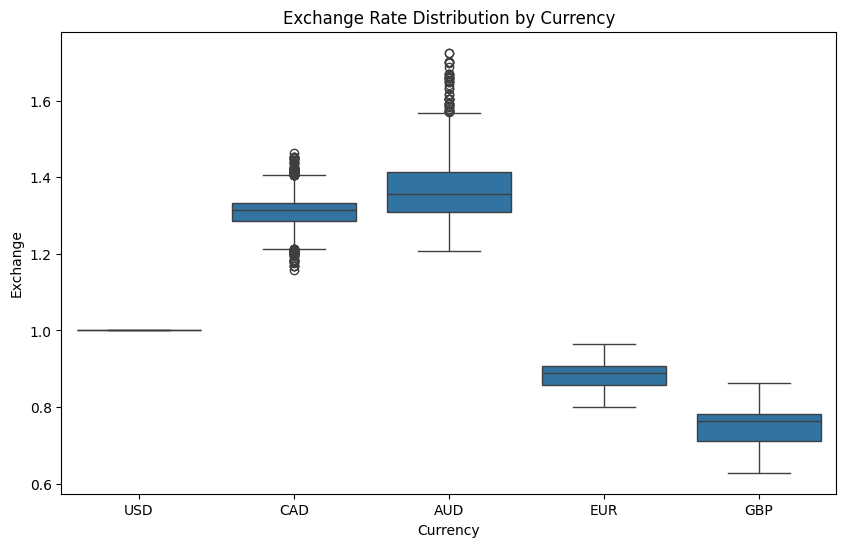

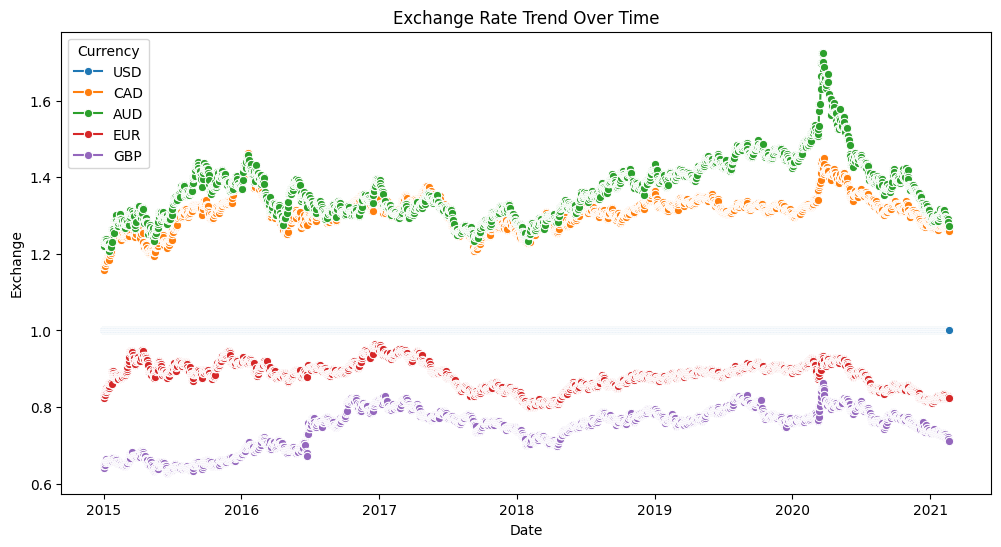

In [6]:
#EDA
print("\nDescriptive Statistics:")
print(exchange_rates.describe())

# Unique currencies
print("\nUnique Currencies:")
print(exchange_rates['Currency'].unique())

# Exchange rate distribution by currency
plt.figure(figsize=(10, 6))
sns.boxplot(x='Currency', y='Exchange', data=exchange_rates)
plt.title('Exchange Rate Distribution by Currency')
plt.show()

# Exchange rate trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=exchange_rates, x='Date', y='Exchange', hue='Currency', marker='o')
plt.title('Exchange Rate Trend Over Time')
plt.show()


In [7]:

# Connecting to MySQL database
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="3008",
    database="global_electronics"
)

cursor = db_connection.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS ExchangeRates (
        Date DATE,
        Currency VARCHAR(10),
        Exchange DECIMAL(10, 4),
        PRIMARY KEY (Date, Currency)
    );
''')

rows_to_insert = [tuple(row) for row in exchange_rates.values]

batch_size = 500

for start in range(0, len(rows_to_insert), batch_size):
    batch = rows_to_insert[start:start + batch_size]
    
    try:
        cursor.executemany('''
            INSERT IGNORE INTO ExchangeRates (Date, Currency, Exchange)
            VALUES (%s, %s, %s)
        ''', batch)
        db_connection.commit()
    except mysql.connector.Error as err:
        print(f"Error in batch {start // batch_size + 1}: {err}")
        db_connection.rollback()

cursor.execute("SELECT COUNT(*) FROM ExchangeRates")
row_count = cursor.fetchone()[0]
print(f"Total exchange rates inserted: {row_count}")
cursor.close()
db_connection.close()


Total exchange rates inserted: 11215
